# 1. Project Overview

## Context
This project focuses on conducting an **A/B Test** for an E-commerce platform. The company has developed a new web page designed to increase the **conversion rate** (the number of users who decide to pay for a product).

## Objectives
The primary goal is to process and analyze interaction logs from both the **Old Page (Control Group)** and the **New Page (Treatment Group)**. The analysis aims to support a data-driven decision-making process regarding the deployment strategy:

- **Deploy:** Launch the new page if it shows a statistically significant improvement.
- **Retain:** Keep the old page if the new version underperforms or shows no significant change.
- **Extend Testing:** Run the experiment longer if the current data is inconclusive to reach a confident decision.

In [1]:
# Setup & Imports
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chisquare, beta
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.multitest import multipletests

# Configuration
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# 2. Dataset Description

The analysis utilizes two datasets containing **294,478** user interaction logs.

## 2.1. Main Dataset (`ab_data.csv`)
| Feature | Description |
| :--- | :--- |
| **user_id** | Unique identifier for each user. |
| **timestamp** | The timestamp of the user's visit. |
| **group** | The experiment group: <br> - `control`: Users seeing the **old_page**. <br> - `treatment`: Users seeing the **new_page**. |
| **landing_page** | The actual web page served to the user (`old_page` or `new_page`). |
| **converted** | The target variable indicating purchase behavior: <br> - `1`: Purchased (Converted). <br> - `0`: Did not purchase. |

## 2.2. Supplemental Data (`countries.csv`)
This dataset provides location information and can be joined with the main dataset via `user_id`.
* **country**: The country of origin for the user (e.g., US, UK, CA).

In [2]:
main_path = "/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1/ab_data.csv"
countries_path = "/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1/countries.csv"

# Load datasets
try:
    df_main = pd.read_csv(main_path)
    df_countries = pd.read_csv(countries_path)

    # print("\nInfo of Main Data")
    # df_main.info()

    # print("\nInfo of Countries Data")
    # df_countries.info()
    
    print(f"Main Data Shape: {df_main.shape}")
    print(f"Countries Data Shape: {df_countries.shape}")
    
    print("\nMain Data Head")
    display(df_main.head())

    print("\nCountries Data Head")
    display(df_countries.head())
except FileNotFoundError:
    print("Error: File not found. Please check the paths.")

Main Data Shape: (294480, 5)
Countries Data Shape: (290586, 2)

Main Data Head


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1



Countries Data Head


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


# 3. Data Engineering Pipeline

To ensure a robust analysis, we construct a data processing pipeline consisting of Data Integration, Deduplication, and Integrity Checks.

## 3.1. Data Integration
**Goal:** Enrich the raw interaction logs with geographical data to enable location-based segmentation later.
- **Operation:** Perform a **Left Join** on `user_id`.
- **Logic:** We keep all interaction logs from the main dataset and attach country codes where available.

In [3]:
# --- Data Integration ---
# Merge main logs with countries data
df_merged = df_main.merge(df_countries, on="user_id", how="left")

print(f"Shape before merge: {df_main.shape}")
print(f"Shape after merge:  {df_merged.shape}")

# Preview data to ensure 'country' column is added
display(df_merged.head())

Shape before merge: (294480, 5)
Shape after merge:  (294482, 6)


,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


## 3.2. Temporal Deduplication
**Goal:** Isolate the user's **first impression** to avoid bias from repeated visits.
- **Problem:** Users may visit the landing page multiple times. Including all visits violates the "independence" assumption of statistical tests.
- **Strategy:**
    1. Keep only the **first** occurrence for each `user_id`.
    2. Drop subsequent duplicate entries.

In [4]:
# --- Temporal Deduplication ---
initial_rows = df_merged.shape[0]

# Drop duplicates, keeping the first entry
df_clean = df_merged.drop_duplicates(subset = ['user_id'], keep = 'first')

# Calculate metrics
dropped_rows = initial_rows - df_clean.shape[0]
print(f"Duplicate records removed: {dropped_rows}")
print(f"Unique users remaining: {df_clean.shape[0]}")

Duplicate records removed: 3897
Unique users remaining: 290585


## 3.3. Mismatch Correction
**Goal:** Standardize the dataset by aligning `landing_page` with the assigned `group`.
- **Assumption:** The `group` assignment (Control/Treatment) is considered the **Source of Truth**. Any mismatch in `landing_page` is treated as a logging error.
- **Action:** Instead of dropping valuable user data, we **correct** the `landing_page` values:
    - If `group == 'control'`, force `landing_page` $\rightarrow$ `'old_page'`.
    - If `group == 'treatment'`, force `landing_page` $\rightarrow$ `'new_page'`

In [5]:
# --- Mismatch Correction ---

# Identify mismatches before correction
mismatch_mask = (
    ((df_clean['group'] == 'treatment') & (df_clean['landing_page'] == 'old_page')) |
    ((df_clean['group'] == 'control') & (df_clean['landing_page'] == 'new_page'))
)
print(f"Mismatches detected before correction: {mismatch_mask.sum()}")

df_clean.loc[df_clean['group'] == 'control', 'landing_page'] = 'old_page'
df_clean.loc[df_clean['group'] == 'treatment', 'landing_page'] = 'new_page'

# Verification: Ensure mismatches are gone
recheck_mismatch = (
    ((df_clean['group'] == 'treatment') & (df_clean['landing_page'] == 'old_page')) |
    ((df_clean['group'] == 'control') & (df_clean['landing_page'] == 'new_page'))
).sum()
print(f"Mismatches remaining after fix: {recheck_mismatch}")

# Create Final Dataframe
df_final = df_clean.copy()

print("=" * 50)
print(f"Final Dataset Shape: {df_final.shape}")
print("=" * 50)

Mismatches detected before correction: 2044
Mismatches remaining after fix: 0
Final Dataset Shape: (290585, 6)


## 3.4. Feature Engineering (String Processing)
**Goal:** Extract session duration from the `MM:SS.f` string format.
- **Strategy:** Split the string directly to extract Minutes and Seconds, avoiding datetime conversion errors.
- **Formula:** $\text{Time} = \text{Minutes} \times 60 + \text{Seconds}$.

In [6]:
# Feature Engineering (String Approach)

# Ensure string type
df_final['timestamp'] = df_final['timestamp'].astype(str)

# Split string by ':' to separate Minutes and Seconds
# Format is MM:SS.f -> Part 0 is MM, Part 1 is SS.f
time_parts = df_final['timestamp'].str.split(':', expand=True)

# Convert extracted parts to numeric
minutes = pd.to_numeric(time_parts[0], errors='coerce')
seconds = pd.to_numeric(time_parts[1], errors='coerce')

# Calculate Total Seconds
df_final['time'] = minutes * 60 + seconds

# Cleanup (Remove rows with bad format that result in NaN)
initial_len = len(df_final)
df_final = df_final.dropna(subset=['time'])

print("-" * 30)
print(f"Rows removed due to bad time format: {initial_len - len(df_final)}")
print(f"Final Dataset Shape: {df_final.shape}")
print("-" * 30)

# Preview
display(df_final[['timestamp', 'time']].head())

------------------------------
Rows removed due to bad time format: 0
Final Dataset Shape: (290585, 7)
------------------------------


,timestamp,time
0,11:48.6,708.6
1,01:45.2,105.2
2,55:06.2,3306.2
3,28:03.1,1683.1
4,52:26.2,3146.2


# 4. Exploratory Data Analysis (EDA)

We begin by summarizing the key metrics: **Conversion Rate** (Did they buy?) and **Time Spent** (How long did they stay?).

## 4.1. Descriptive Statistics
**Goal:** Reproduce the summary tables to compare performance between the `old_page` and `new_page`.
- **n:** Sample size.
- **tb (Mean Time):** Average time spent on the page (seconds).
- **sd (Std Time):** Standard deviation of time.
- **Conversion Rate:** Percentage of users who converted.

In [7]:
# Descriptive Statistics

# General Summary by Landing Page
summary_general = df_final.groupby('landing_page').agg(
    n=('user_id', 'count'),
    conversion_rate=('converted', 'mean'),
    tb_time=('time', 'mean'),
    sd_time=('time', 'std')
).reset_index()

display(summary_general)

# Detailed Summary by Page & Conversion Status
summary_detailed = df_final.groupby(['landing_page', 'converted']).agg(
    n=('user_id', 'count'),
    tb_time=('time', 'mean'),
    sd_time=('time', 'std')
).reset_index()

display(summary_detailed)

# Quick Observation
p_old = summary_general.loc[summary_general['landing_page'] == 'old_page', 'conversion_rate'].values[0]
p_new = summary_general.loc[summary_general['landing_page'] == 'new_page', 'conversion_rate'].values[0]
print(f"\nObservation: Old Rate ({p_old:.2%}) vs New Rate ({p_new:.2%})")

,landing_page,n,conversion_rate,tb_time,sd_time
0,new_page,145353,0.118842,1801.561902,1039.123734
1,old_page,145232,0.120297,1804.922550,1037.313523


,landing_page,converted,n,tb_time,sd_time
0,new_page,0,128079,1801.442659,1039.534724
1,new_page,1,17274,1802.446035,1036.100925
2,old_page,0,127761,1806.096534,1037.039892
3,old_page,1,17471,1796.337502,1039.301750



Observation: Old Rate (12.03%) vs New Rate (11.88%)


### Observations from Descriptive Statistics

Based on the summary tables above, we can draw the following preliminary insights:

1.  **Sample Size:** The traffic is evenly distributed (~145,000 users each), confirming valid randomization.
2.  **User Engagement:** Users spent **slightly less time** on the New Page (1801.5s) compared to the Old Page (1804.9s).
3.  **Conversion Performance:** The conversion rate for the New Page ($11.88\%$) is **lower** than the baseline ($12.03\%$).

**Preliminary Conclusion:** The New Page is underperforming in both engagement and conversion.

## 4.2. Visual Analysis
We perform visualization in two stages:
1.  **Primary KPI Analysis (Conversion):** Check sample balance, class imbalance, and conversion rates.
2.  **Secondary Metric Analysis (Time):** Analyze user engagement depth using Boxplots.

### 4.2.1. Primary KPI: Conversion Analysis
First, we analyze the Conversion Rate from multiple angles: Overview, Class Distribution, and Confidence Intervals.

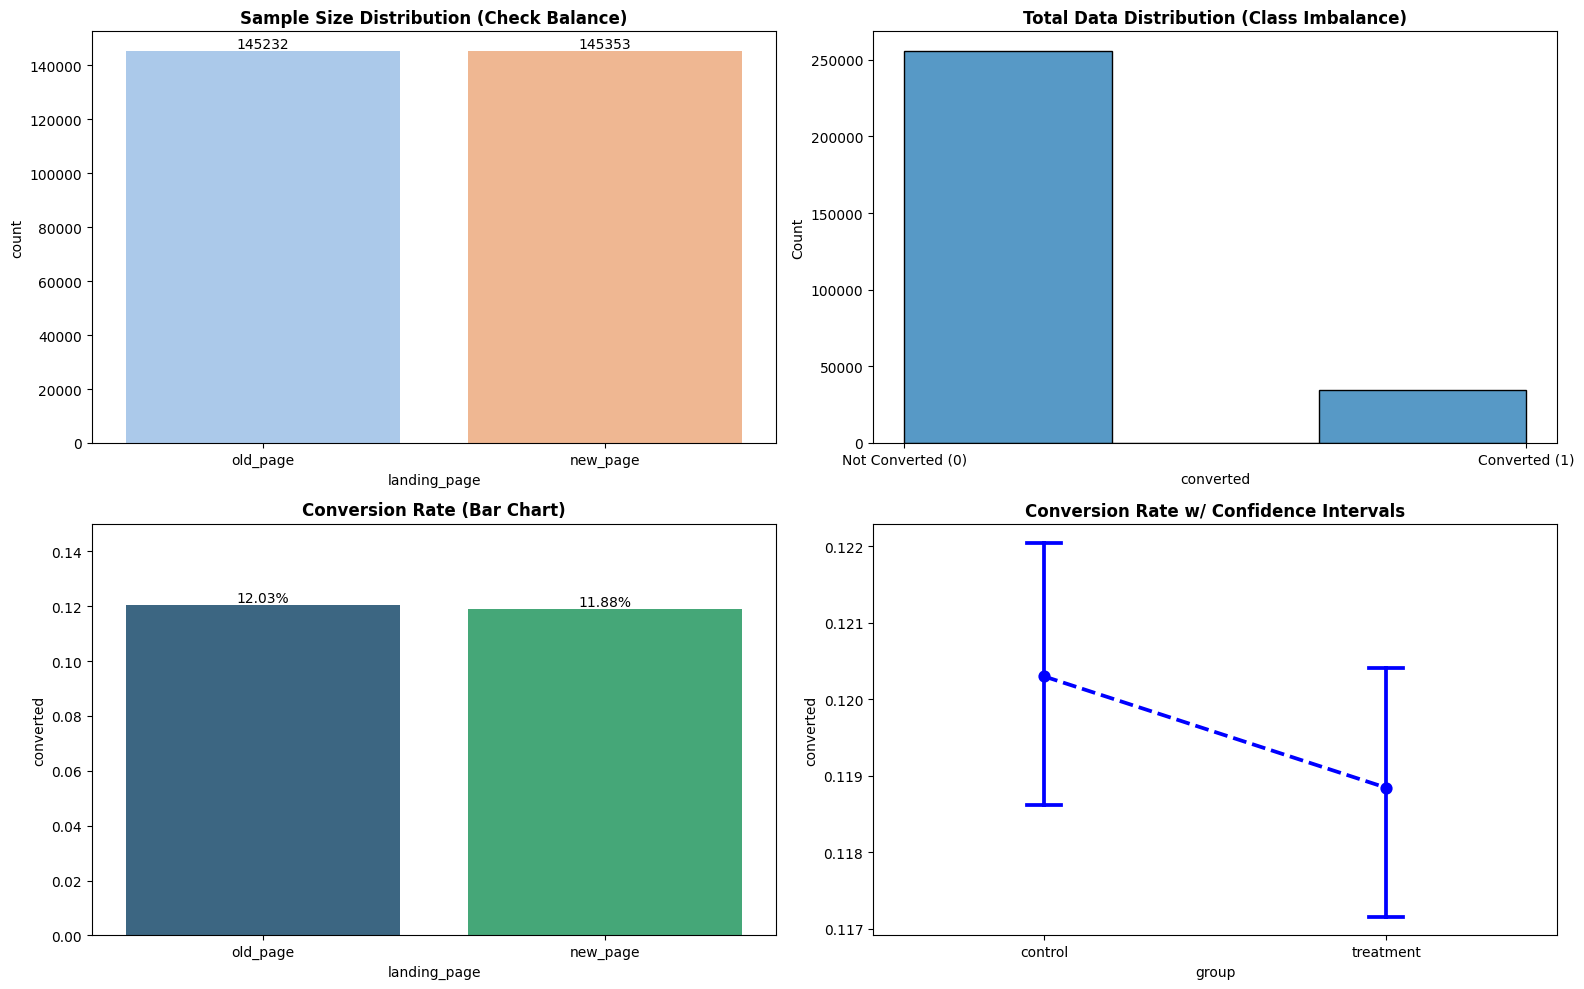

In [8]:
# Conversion Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.countplot(x='landing_page', data=df_final, ax=axes[0, 0], palette="pastel")
axes[0, 0].set_title('Sample Size Distribution (Check Balance)', fontsize=12, fontweight='bold')
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10)

sns.histplot(df_final['converted'], kde=False, bins=3, ax=axes[0, 1])
axes[0, 1].set_title('Total Data Distribution (Class Imbalance)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Not Converted (0)', 'Converted (1)'])

sns.barplot(x='landing_page', y='converted', data=df_final, ax=axes[1, 0], palette="viridis", errorbar=None)
axes[1, 0].set_title('Conversion Rate (Bar Chart)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 0.15)
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10)

sns.pointplot(x='group', y='converted', data=df_final, ax=axes[1, 1], capsize=.1, linestyles="--", markers="o", color="b")
axes[1, 1].set_title('Conversion Rate w/ Confidence Intervals', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Observations from Visual Analysis

Based on the dashboard visualizations above, we derive the following key insights regarding the experiment's validity and performance:

1. **Experiment Validity (Sample Balance):**
The **Sample Size Distribution** chart confirms that traffic was split evenly between the two groups (~145,000 users each). This validates the randomization process, ensuring that any difference in performance is due to the page design, not traffic volume.
2. **Dataset Characteristics (Class Imbalance):**
The **Total Data Distribution** plot highlights a significant class imbalance. The vast majority of users do not convert (Outcome 0), with conversions (Outcome 1) being a relatively rare event ($~12\%$). This suggests that detecting a "lift" requires a highly sensitive test given the large volume of non-events.
3. **Primary KPI (Conversion Performance):**
* **Bar Chart:** Visually confirms that the `old_page` ($12.03\%$) has a slight edge over the `new_page` ($11.88\%$).
* **Point Plot (Confidence Intervals):** This is the most critical visual. The downward slope from Control to Treatment indicates a **negative trend**. The confidence intervals (vertical bars) for the two groups do not show a positive overlap, strongly suggesting that the new page is likely performing worse, not better.

**Preliminary Conclusion:**
The visual evidence paints a clear picture: the New Page is **underperforming**. It failed to improve user retention (Time) and appears to negatively impact the primary goal (Conversion Rate). We will now confirm if this observed drop is statistically significant using Hypothesis Testing.

### 4.2.2. Secondary Metric: Time Analysis (Deep Dive)
Finally, we investigate the **Time Spent** to see if the new page engages users longer, even if they don't buy.
- **Boxplot:** To compare medians and detect outliers.
- **Histogram:** To understand the density of user engagement.

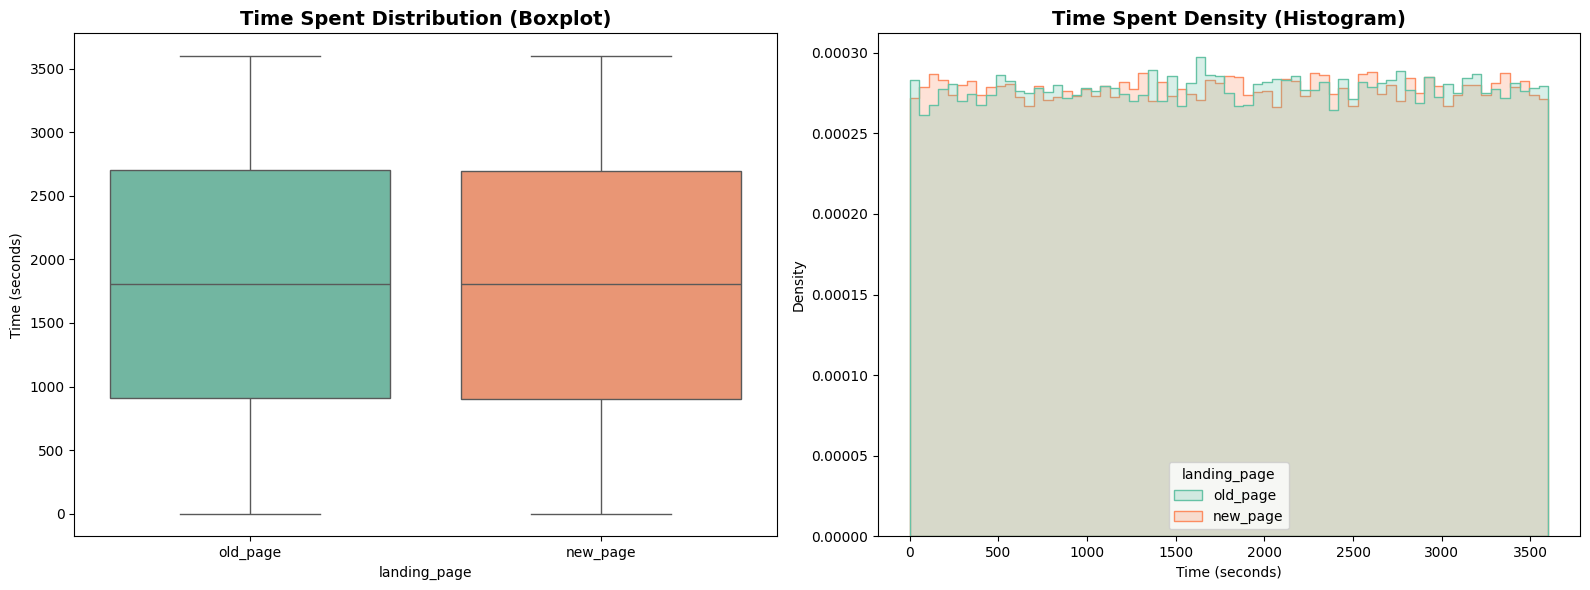

In [9]:
# Time Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Boxplot (Distribution & Outliers)
sns.boxplot(x='landing_page', y='time', data=df_final, ax=axes[0], palette="Set2")
axes[0].set_title('Time Spent Distribution (Boxplot)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Time (seconds)')

# Chart 2: Histogram (Density)
sns.histplot(data=df_final, x='time', hue='landing_page', element="step", stat="density", common_norm=False, ax=axes[1], palette="Set2")
axes[1].set_title('Time Spent Density (Histogram)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.show()

### Key Insights from Time Analysis

- **No Significant Difference:** Both the Boxplot and Histogram show that the distribution of time spent is identical between the `old_page` and `new_page`.
- **Behavioral Pattern:** The data follows a **uniform distribution**. The median time remains stable at $\sim30$ minutes for both groups.
- **Implication:** The redesign failed to alter user engagement behavior.

# 5. Statistical Hypothesis Testing (A/B Testing)

To scientifically answer the question: **"Is the new website effectively better than the old one?"**, we perform a statistical inference test.

## 5.1. Hypothesis Definition
We define the conversion rates for the old and new pages as $p_{\text{old}}$ and $p_{\text{new}}$.

* **Null Hypothesis ($H_0$):** $p_{\text{new}} \le p_{\text{old}}$
    *(The New Page is not better; it is equal to or worse than the Old Page).*
* **Alternative Hypothesis ($H_1$):** $p_{\text{new}} > p_{\text{old}}$
    *(The New Page is strictly better than the Old Page).*
* **Significance Level ($\alpha$):** 0.05 ($95\%$ Confidence Level).

**Methodology:**
Unlike the *Permutation Test* used in smaller datasets, we utilize the **Two-Proportions Z-Test** for this analysis. This is the industry standard for large datasets ($N > 30$) and provides statistically equivalent results to simulation methods but is more computationally efficient.

In [10]:
n_new_converted = df_final[(df_final['landing_page'] == 'new_page') & (df_final['converted'] == 1)].shape[0]
n_old_converted = df_final[(df_final['landing_page'] == 'old_page') & (df_final['converted'] == 1)].shape[0]

n_new_total = df_final[df_final['landing_page'] == 'new_page'].shape[0]
n_old_total = df_final[df_final['landing_page'] == 'old_page'].shape[0]

counts = np.array([n_new_converted, n_old_converted])
nobs = np.array([n_new_total, n_old_total])

print(f"New Page: {n_new_converted}/{n_new_total} converted (Rate: {n_new_converted/n_new_total:.4f})")
print(f"Old Page: {n_old_converted}/{n_old_total} converted (Rate: {n_old_converted/n_old_total:.4f})")

New Page: 17274/145353 converted (Rate: 0.1188)
Old Page: 17471/145232 converted (Rate: 0.1203)


## 5.2. Test Execution
We utilize the `proportions_ztest` function from the `statsmodels` library to calculate the P-value.

* **Decision Rule:**
    * If $P_{value} < 0.05$: Reject $H_0$ $\rightarrow$ The New Page is significantly better.
    * If $P_{value} \ge 0.05$: Fail to reject $H_0$ $\rightarrow$ The New Page is not better.

In [11]:
# Run
z_stat, p_value = proportions_ztest(counts, nobs, alternative='larger')

print(f"Z-Test Results")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

alpha = 0.05
print("\nSTATISTICAL DECISION")

if p_value < alpha:
    print("Result: REJECT H0.")
    print("Interpretation: The New Page is statistically better than the Old Page.")
else:
    print("Result: FAIL TO REJECT H0.")
    print(f"Interpretation: The difference is not statistically significant (p-value {p_value:.4f} > {alpha}).")
    print("Evidence suggests the New Page is NOT better.")

Z-Test Results
Z-Statistic: -1.2091
P-Value: 0.8867

STATISTICAL DECISION
Result: FAIL TO REJECT H0.
Interpretation: The difference is not statistically significant (p-value 0.8867 > 0.05).
Evidence suggests the New Page is NOT better.


## 5.3. Final Business Conclusion

**Statistical Analysis:**
The test resulted in a p-value of approximately **$0.8867$**, which is significantly higher than our alpha level of $0.05$.
* Mathematically, this means we **fail to reject the Null Hypothesis ($H_0$)**.
* The probability that the New Page is "better" by random chance is close to zero, given that the observed data actually shows a decline.

**Business Recommendation:**
1.  **Performance:** The New Page conversion rate ($11.88\%$) is statistically equivalent to (or slightly worse than) the Old Page ($12.03\%$).
2.  **Engagement:** As seen in the EDA section, the new design failed to increase user session duration.
3.  **Action:** The company **should NOT deploy** the new landing page.
    * **Reasoning:** Implementing the new page would incur deployment costs without providing any revenue uplift.